In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import ast
from datetime import datetime
from enum import Enum
from typing import List, Optional
import gym
from gym import spaces
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import configure
from tqdm.notebook import tqdm
import torch
from torch import nn
import csv

### Data Model Classes

In [2]:
class InteractionType(Enum):
    """
    Enum for different types of interactions a customer can have.
    """

    NONE = "none"
    VIEW = "view"
    LIKE = "like"
    BUY = "buy"
    RATE = "rate"
    EXIT = "exit"
    SESSION_START = "session_start"
    SESSION_CLOSE = "session_close"

In [3]:
class Interaction:
    """
    Represents a single interaction between a customer and a product.
    """

    def __init__(
        self,
        idx: str,
        timestamp: datetime,
        customer_idx: int,
        product_idx: int,
        type: InteractionType,
        value: Optional[float] = None,
        review_score: Optional[int] = None,
        city_embedding: Optional[List[float]] = None,
        state_embedding: Optional[List[float]] = None,
        zip_code_embedding: Optional[List[float]] = None,
        product_purchase_history: Optional[List[float]] = None,
        category_purchase_history: Optional[List[float]] = None,
        rate_history: Optional[List[float]] = None,
    ) -> None:
        self.idx = idx
        self.timestamp = timestamp
        self.customer_idx = customer_idx
        self.product_idx = product_idx
        self.type = type
        self.value = value
        self.review_score = review_score
        self.city_embedding = city_embedding
        self.state_embedding = state_embedding
        self.zip_code_embedding = zip_code_embedding
        self.product_purchase_history = product_purchase_history
        self.category_purchase_history = category_purchase_history
        self.rate_history = rate_history

In [4]:
class Customer:
    def __init__(self, idx: int, zip_code: int, city: str, state: str, interactions: Optional[List[Interaction]] = None) -> None:
        self.idx = idx
        self.zip_code = zip_code
        self.city = city
        self.state = state
        self.interactions = interactions if interactions is not None else []

In [5]:
class Category:
    def __init__(self, idx: int, name: str, desc: str) -> None:
        self.idx = idx
        self.name = name
        self.desc = desc

In [6]:
class Product:
    def __init__(self, idx: int, name: str, desc: str, long_desc: str, category: Category, price: float) -> None:
        self.idx = idx
        self.name = name
        self.desc = desc
        self.long_desc = long_desc
        self.category = category
        self.price = price

### Data Loader Functions

In [7]:
def load_customers(idxs: List[int] = [], include_interactions: bool = False) -> List[Customer]:
    """
    Loads customer data from a CSV file.

    Parameters:
    - idxs: List of customer indices to load.
    - include_interactions: Whether to include interactions data.

    Returns:
    - List of Customer objects.
    """
    customer_df = pd.read_csv("../data/preprocessed_data/Customer.csv")
    interaction_df = pd.read_csv("../data/preprocessed_data/Interaction.csv") if include_interactions else None

    if idxs:
        customer_df = customer_df[customer_df["idx"].isin(idxs)]

    customers = []
    for _, row in tqdm(customer_df.iterrows(), total=len(customer_df), desc="Loading Customers"):
        interactions = []
        if include_interactions:
            customer_interactions = interaction_df[interaction_df["customer_idx"] == row["idx"]]
            for _, int_row in customer_interactions.iterrows():
                interactions.append(
                    Interaction(
                        idx=int_row["idx"],
                        timestamp=datetime.strptime(int_row["timestamp"], "%Y-%m-%d %H:%M:%S"),
                        customer_idx=int_row["customer_idx"],
                        product_idx=int_row["product_idx"],
                        type=InteractionType(int_row["type"]),
                        value=int_row["value"],
                        review_score=int_row["review_score"],
                    )
                )

        customers.append(Customer(idx=row["idx"], zip_code=row["zip_code"], city=row["city"], state=row["state"], interactions=interactions))
    return customers

In [8]:
def parse_vector_field(field: str) -> List[float]:
    """
    Parses a string representation of a list into an actual list.

    Parameters:
    - field: String representation of a list.

    Returns:
    - List of floats.
    """
    try:
        return ast.literal_eval(field) if field else []
    except (ValueError, SyntaxError):
        return []

In [9]:
def load_interactions(idxs: List[int] = [], customer_idxs: List[int] = [], k: int = 0) -> List[Interaction]:
    """
    Loads interaction data from a CSV file.

    Parameters:
    - idxs: List of interaction indices to load.
    - customer_idxs: List of customer indices to filter interactions.
    - k: Number of interactions to load.

    Returns:
    - List of Interaction objects.
    """
    interaction_df = pd.read_csv("../data/preprocessed_data/Customer_Interactions.csv")

    if idxs:
        interaction_df = interaction_df[interaction_df["idx"].isin(idxs)]
    elif customer_idxs:
        interaction_df = interaction_df[interaction_df["customer_idx"].isin(customer_idxs)]

    if k > 0:
        interaction_df = interaction_df.sort_values(by="timestamp", ascending=False).head(k)

    interactions = []
    for _, row in tqdm(interaction_df.iterrows(), total=len(interaction_df), desc="Loading Interactions"):
        interactions.append(
            Interaction(
                idx=row["idx"],
                timestamp=datetime.strptime(row["timestamp"], "%Y-%m-%d %H:%M:%S"),
                customer_idx=row["customer_idx"],
                product_idx=row["product_idx"],
                type=InteractionType(row["type"]),
                value=row["value"],
                review_score=row["review_score"],
                city_embedding=parse_vector_field(row["city_embedding"]),
                state_embedding=parse_vector_field(row["state_embedding"]),
                zip_code_embedding=parse_vector_field(row["zip_code_embedding"]),
                product_purchase_history=parse_vector_field(row["product_purchase_history"]),
                category_purchase_history=parse_vector_field(row["category_purchase_history"]),
                rate_history=parse_vector_field(row["rate_history"]),
            )
        )
    return interactions

In [10]:
def store_interactions(interactions: List[Interaction]):
    """
    Stores interactions data back to a CSV file.

    Parameters:
    - interactions: List of Interaction objects.
    """
    interaction_data = [
        {
            "idx": i.idx,
            "timestamp": i.timestamp.strftime("%Y-%m-%d %H:%M:%S"),
            "customer_idx": i.customer_idx,
            "product_idx": i.product_idx,
            "type": i.type.value,
            "value": i.value,
            "review_score": i.review_score,
        }
        for i in interactions
    ]
    interaction_df = pd.DataFrame(interaction_data)
    interaction_df.to_csv("../data/preprocessed_data/Interaction.csv", index=False)

In [11]:
def load_categories(idxs: List[int] = []) -> List[Category]:
    """
    Loads category data from a CSV file.

    Parameters:
    - idxs: List of category indices to load.

    Returns:
    - List of Category objects.
    """
    category_df = pd.read_csv("../data/preprocessed_data/Category.csv")
    if idxs:
        category_df = category_df[category_df["idx"].isin(idxs)]

    categories = [Category(idx=row["idx"], name=row["name"], desc=row["desc"]) for _, row in category_df.iterrows()]
    return categories

In [12]:
def load_products(idxs: List[int] = []) -> List[Product]:
    """
    Loads product data from a CSV file.

    Parameters:
    - idxs: List of product indices to load.

    Returns:
    - List of Product objects.
    """
    product_df = pd.read_csv("../data/preprocessed_data/Product.csv")
    category_df = pd.read_csv("../data/preprocessed_data/Category.csv")

    category_map = {row["idx"]: Category(idx=row["idx"], name=row["name"], desc=row["desc"]) for _, row in category_df.iterrows()}

    if idxs:
        product_df = product_df[product_df["idx"].isin(idxs)]

    products = []
    for _, row in product_df.iterrows():
        category = category_map.get(row["category_num_id"])
        products.append(Product(idx=row["idx"], name=row["name"], desc=row["desc"], long_desc=row["long_desc"], category=category, price=row["price"]))
    return products

In [13]:
# Load interaction data and product data
interactions = load_interactions()
products = [p.idx for p in load_products()]

Loading Interactions:   0%|          | 0/1338 [00:00<?, ?it/s]

### Custom Environment

In [14]:
class RecommendationEnv(gym.Env):
    """
    Custom Environment for a recommendation system using reinforcement learning.

    The environment simulates a user's interaction with a recommendation system,
    using the user's history and embeddings to generate observations, and
    calculates rewards based on the agent's recommended products.
    """

    def __init__(self, interactions_data: List[Interaction], products_data: List[int], top_k: int = 5):
        super(RecommendationEnv, self).__init__()
        self.interactions_data = interactions_data
        self.products_data = products_data
        self.top_k = top_k
        self.current_interaction_idx = 0

        # Define action space for SAC (continuous action space)
        self.action_space = spaces.Box(low=-1, high=1, shape=(top_k,), dtype=np.float32)

        # Flatten observation space by concatenating all components into a single Box space
        example_interaction = interactions_data[0]
        observation_dim = (
            len(example_interaction.product_purchase_history or products_data)
            + len(example_interaction.category_purchase_history or products_data)
            + len(example_interaction.rate_history or products_data)
            + len(example_interaction.city_embedding or [0] * 12)
            + len(example_interaction.state_embedding or [0] * 12)
            + len(example_interaction.zip_code_embedding or [0] * 12)
        )
        self.observation_space = spaces.Box(low=0, high=1, shape=(observation_dim,), dtype=np.float32)

        # Reward mapping for interaction types
        self.reward_mapping = {
            "buy": 5.0,
            "rate": 3.0,
            "like": 2.0,
            "view": 1.0,
            "none": -1.0,
            "exit": -2.0,
        }

    def seed(self, seed=None):
        """Sets the random seed for the environment."""
        self._seed = seed
        np.random.seed(seed)

    def reset(self):
        """Resets the environment to an initial state and returns an initial observation."""
        self.current_interaction_idx = np.random.randint(len(self.interactions_data))
        return self._get_observation()

    def step(self, action):
        """
        Executes one time step within the environment.

        Parameters:
        - action: The action taken by the agent.

        Returns:
        - obs: The next observation.
        - reward: The reward received.
        - done: Whether the episode has ended.
        - info: Additional information.
        """
        # Convert continuous actions to discrete product indices
        recommended_products = np.clip((action + 1) * (len(self.products_data) / 2), 0, len(self.products_data) - 1).astype(int)

        # Select current interaction and simulate a response
        interaction = self.interactions_data[self.current_interaction_idx]
        simulated_response = self._simulate_user_response(interaction, recommended_products)

        # Assign reward based on simulated user response
        reward = self.reward_mapping.get(simulated_response, 0.0)

        # Update index and check if the session is done
        self.current_interaction_idx = (self.current_interaction_idx + 1) % len(self.interactions_data)
        done = simulated_response == "exit"

        obs = self._get_observation()
        return obs, reward, done, {}

    def _simulate_user_response(self, interaction, recommended_products):
        """
        Simulates a user response based on interaction history and recommended products.

        This is a simplified function where the response type is randomly chosen for demonstration.
        In a real system, it would be influenced by actual interaction patterns.
        """
        # Randomly simulate a response; replace this with a model-based response if available
        return np.random.choice(["buy", "rate", "like", "view", "none", "exit"])

    def _get_observation(self):
        """Retrieves the current observation based on the current interaction."""
        interaction = self.interactions_data[self.current_interaction_idx]
        obs = np.concatenate(
            [
                np.array(interaction.product_purchase_history or np.zeros(len(self.products_data)), dtype=np.float32),
                np.array(interaction.category_purchase_history or np.zeros(len(self.products_data)), dtype=np.float32),
                np.array(interaction.rate_history or np.zeros(len(self.products_data)), dtype=np.float32),
                np.array(interaction.city_embedding or np.zeros(12), dtype=np.float32),
                np.array(interaction.state_embedding or np.zeros(12), dtype=np.float32),
                np.array(interaction.zip_code_embedding or np.zeros(12), dtype=np.float32),
            ]
        )
        return obs

    def render(self, mode="human"):
        """Renders the environment (for debugging purposes)."""
        print(f"Current Interaction Index: {self.current_interaction_idx}")
        print(f"Recommended Product Indices: {self.products_data}")

    def close(self):
        """Performs any necessary cleanup."""
        pass

### Initialize environment

In [15]:
# Initialize the environment
env = RecommendationEnv(interactions_data=interactions, products_data=products, top_k=5)

# Wrap the environment for vectorized training
vec_env = make_vec_env(lambda: env, n_envs=4)

c:\Users\farha\miniconda3\envs\rl_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


#### Logging

In [16]:
# Custom callback to log rewards for plotting
class RewardLoggingCallback(BaseCallback):
    def __init__(self, log_file="training_rewards.csv", verbose=0):
        super(RewardLoggingCallback, self).__init__(verbose)
        self.rewards = []
        self.log_file = log_file

        # Open the file in write mode and add a header row for the CSV log
        with open(self.log_file, mode="w", newline="") as file:
            writer = csv.writer(file)
            writer.writerow(["Timestep", "Reward"])

    def _on_step(self) -> bool:
        # Get the reward from the last step
        reward = self.locals.get("rewards")  # Get rewards from `self.locals`
        if reward:
            reward_value = reward[0]  # Assuming single environment
            self.rewards.append(reward_value)

            # Append the reward and timestep to the CSV file
            with open(self.log_file, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([self.num_timesteps, reward_value])

        return True

In [17]:
# Set up TensorBoard logging directory
tensorboard_log_dir = "./tensorboard_logs/"
os.makedirs(tensorboard_log_dir, exist_ok=True)

# Configure TensorBoard logger
new_logger = configure(tensorboard_log_dir, ["tensorboard"])

### Initialize model

In [18]:
# Initialize SAC model with TensorBoard logging
model = SAC(
    policy="MlpPolicy",
    env=env,
    verbose=1,
    learning_rate=2e-3,
    buffer_size=10000,
    batch_size=256,
    learning_starts=1000,
    train_freq=10,
    gradient_steps=4,
    ent_coef="auto",
    tau=0.005,
    gamma=0.95,
    policy_kwargs=dict(
        net_arch=[256, 256],
        activation_fn=torch.nn.ReLU,
    ),
    tensorboard_log=tensorboard_log_dir,
)

model.set_logger(new_logger)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [19]:
# Initialize custom callbacks
total_timesteps = 250000
reward_callback = RewardLoggingCallback()

# Initialize the callback with CSV logging
reward_callback = RewardLoggingCallback(log_file="training_rewards.csv")

In [20]:
# Train the model with both progress and reward logging callbacks
model.learn(
    total_timesteps=total_timesteps,
    callback=[
        # progress_callback,
        reward_callback
    ],
    progress_bar=True,
)

Output()

In [21]:
# Save the trained model
model.save("sac_recommendation_model")

### Plots

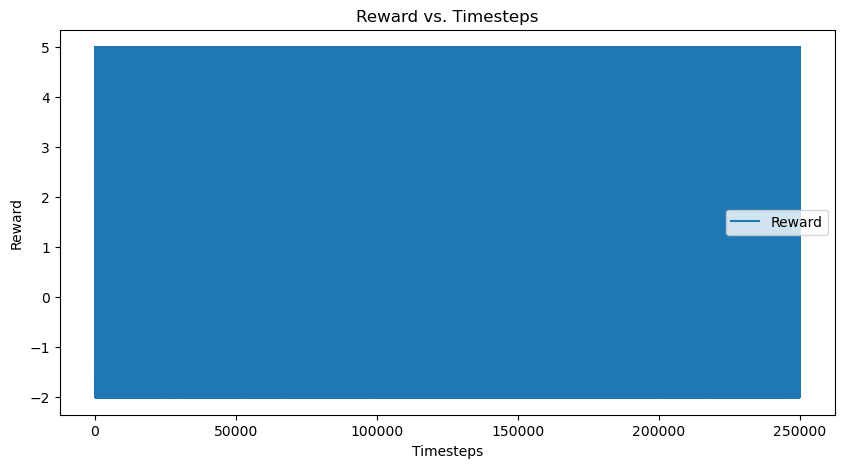

In [22]:
# Plotting training metrics
def plot_training_metrics(rewards):
    # Plot rewards over timesteps
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Reward")
    plt.xlabel("Timesteps")
    plt.ylabel("Reward")
    plt.title("Reward vs. Timesteps")
    plt.legend()
    plt.show()


# Plot the rewards collected from callback
plot_training_metrics(reward_callback.rewards)

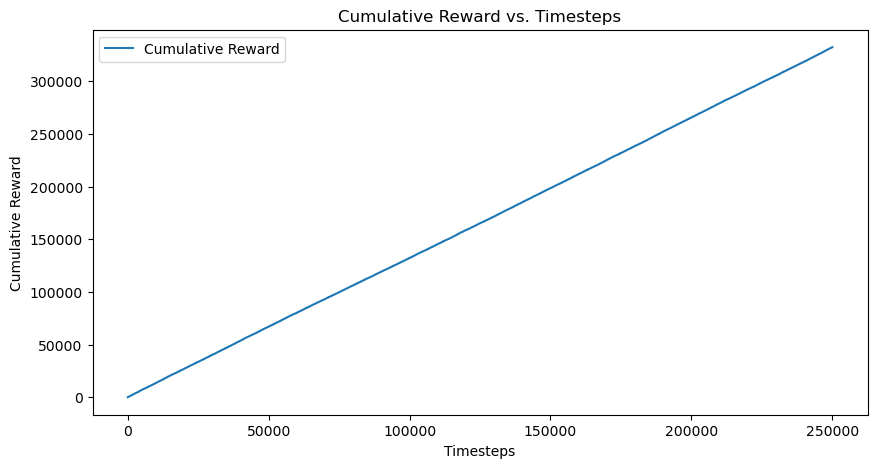

In [23]:
# Plot cumulative rewards
cumulative_rewards = np.cumsum(reward_callback.rewards)
plt.figure(figsize=(10, 5))
plt.plot(cumulative_rewards, label="Cumulative Reward")
plt.xlabel("Timesteps")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward vs. Timesteps")
plt.legend()
plt.show()

In [24]:
# def plot_rewards_from_csv(csv_file="training_rewards.csv"):
#     df = pd.read_csv(csv_file)
#     plt.figure(figsize=(10, 5))
#     plt.plot(df["Timestep"], df["Reward"], label="Reward")
#     plt.xlabel("Timestep")
#     plt.ylabel("Reward")
#     plt.title("Reward vs. Timesteps")
#     plt.legend()
#     plt.show()


# # Plot the rewards from the CSV file
# plot_rewards_from_csv("training_rewards.csv")